In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Add src to path so we can import our modules
sys.path.append(os.path.abspath(os.path.join('..')))

from src.model_arima import split_data, train_arima, evaluate_forecast, save_model

# Configure Plotting
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)

print("Setup Complete.")

Setup Complete.


In [5]:
# CELL 2: LOAD DATA
# ==========================================
# Load the cleaned data from Task 1
try:
    df = pd.read_csv('../data/processed/cleaned_close_prices.csv', index_col=0, parse_dates=True)
    tsla = df['TSLA']
    print(f"Data Loaded. Range: {tsla.index.min().date()} to {tsla.index.max().date()}")
except FileNotFoundError:
    print("ERROR: Data file not found. Did you run Notebook 01?")

# Check for NaNs and fill if necessary
if tsla.isnull().sum() > 0:
    print(f"Warning: Found {tsla.isnull().sum()} NaNs in TSLA data. Filling...")
    tsla = tsla.ffill()


Data Loaded. Range: 2015-01-02 to 2026-01-14


Training Samples: 2220 (2015-01-02 - 2023-10-26)
Testing Samples:  555 (2023-10-27 - 2026-01-14)


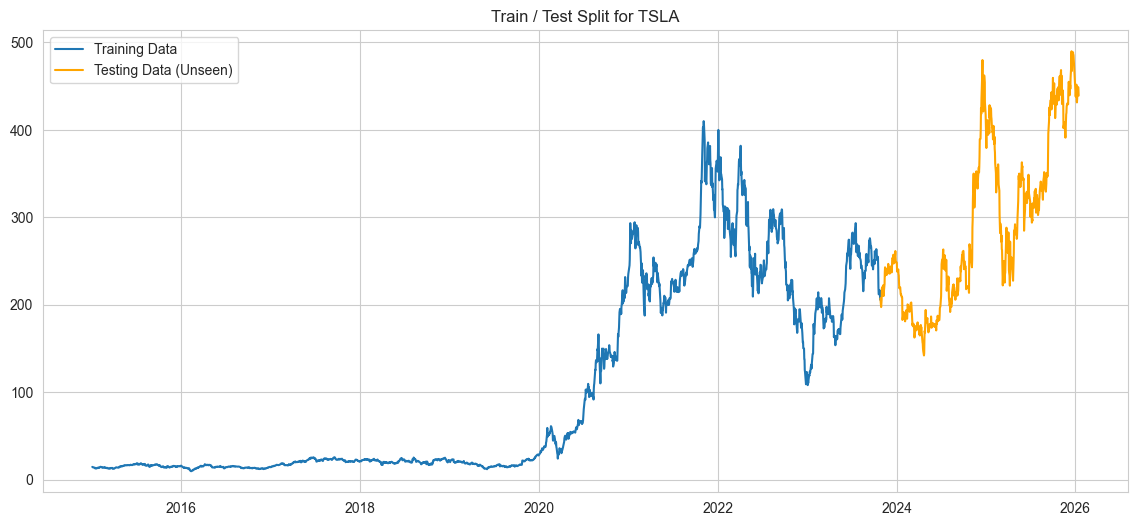

In [6]:
# CELL 3: TRAIN-TEST SPLIT
# ==========================================
# Split data (80% Train, 20% Test) - strictly chronological
train, test = split_data(tsla, split_ratio=0.8)

print(f"Training Samples: {len(train)} ({train.index.min().date()} - {train.index.max().date()})")
print(f"Testing Samples:  {len(test)} ({test.index.min().date()} - {test.index.max().date()})")

# Visualize the split
plt.figure(figsize=(14, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Testing Data (Unseen)', color='orange')
plt.title('Train / Test Split for TSLA')
plt.legend()
plt.show()

In [7]:
# CELL 4: TRAIN ARIMA MODEL
# ==========================================
print("Training Auto-ARIMA model... (This may take 10-30 seconds)")
model = train_arima(train)
print("Model Training Complete.")
print(model.summary())

Training Auto-ARIMA model... (This may take 10-30 seconds)
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=14030.013, Time=1.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14028.054, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14027.854, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14027.925, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14026.560, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14028.187, Time=0.28 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.726 seconds
Model Training Complete.
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2220
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -7012.280
Date:                Sun, 15 Feb 2026   AIC                          14026.560
Time:                        22:35:26   BIC                          14032.265

Plotting Diagnostics...


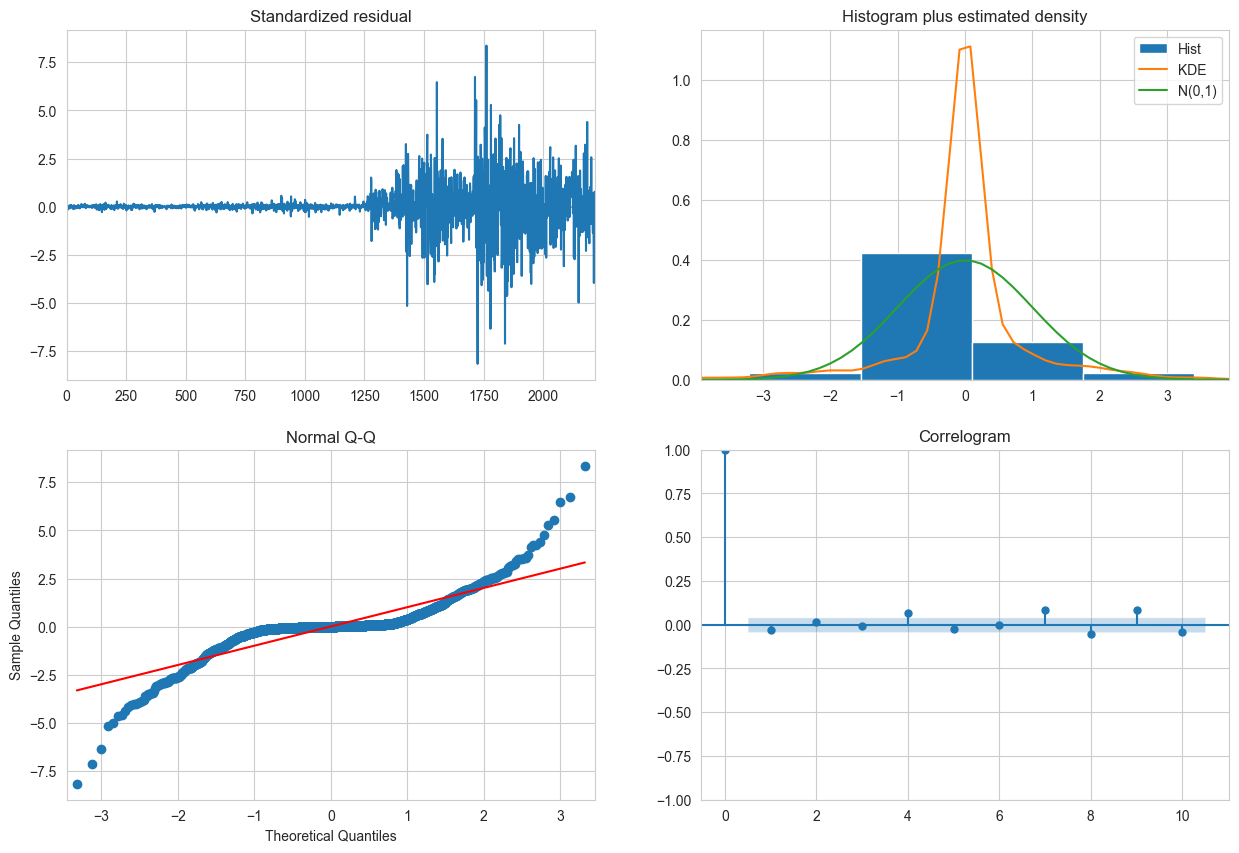

In [8]:
# CELL 5: DIAGNOSTICS
# ==========================================
print("Plotting Diagnostics...")
model.plot_diagnostics(figsize=(15, 10))
plt.show()

Generating Forecast...


/Users/abbygail/portfolio-optimization/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/abbygail/portfolio-optimization/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


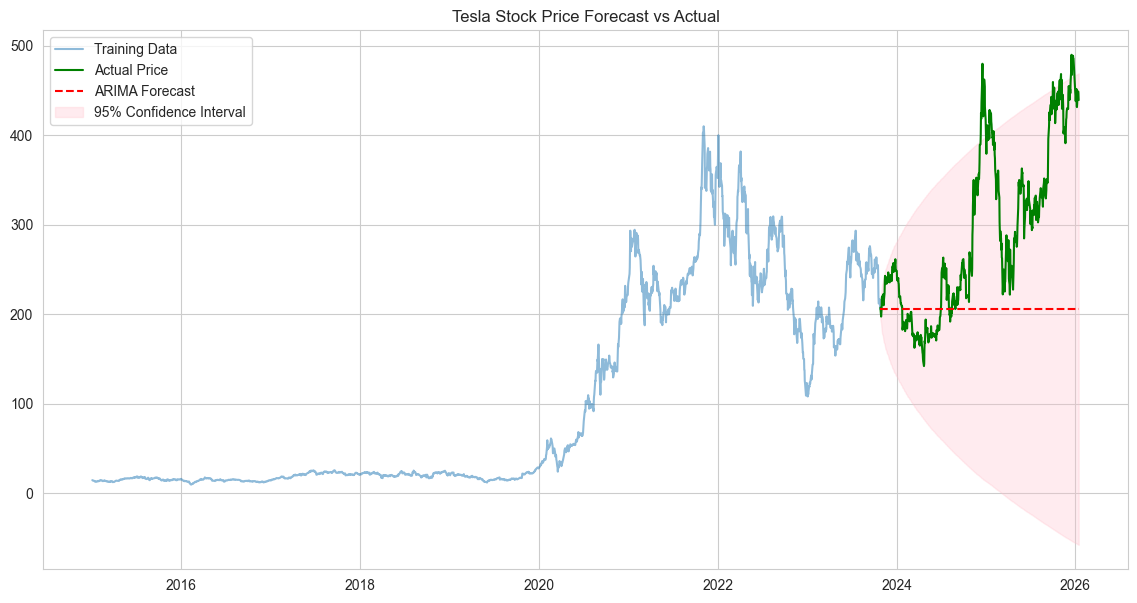

In [9]:
# CELL 6: FORECASTING
# ==========================================
print("Generating Forecast...")

# Get predictions and confidence intervals
# We explicitly handle the index to prevent the 'NaN' error you saw earlier
n_periods = len(test)
raw_predictions, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

# 1. Handle Predictions (Fix Index Mismatch)
# If it's a Series, get .values. If it's an array, keep it.
pred_values = raw_predictions.values if hasattr(raw_predictions, 'values') else raw_predictions
predictions = pd.Series(pred_values, index=test.index)

# 2. Handle Confidence Intervals
conf_int_df = pd.DataFrame(conf_int, index=test.index, columns=['Lower', 'Upper'])

# Plot Forecast vs Actual
plt.figure(figsize=(14, 7))
plt.plot(train, label='Training Data', alpha=0.5)
plt.plot(test, label='Actual Price', color='green')
plt.plot(predictions, label='ARIMA Forecast', color='red', linestyle='--')
plt.fill_between(conf_int_df.index, conf_int_df['Lower'], conf_int_df['Upper'], color='pink', alpha=0.3, label='95% Confidence Interval')
plt.title('Tesla Stock Price Forecast vs Actual')
plt.legend()
plt.show()

In [10]:
# ==========================================
# CELL 7: EVALUATION
# ==========================================
import sys
import os
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# FIX: Add the project root to path so Python finds 'src'
sys.path.append(os.path.abspath(os.path.join('..')))

# NOW import the custom function
from src.model_arima import save_model

# Calculate Error Metrics
mae = mean_absolute_error(test, predictions)
rmse = np.sqrt(mean_squared_error(test, predictions))
mape = np.mean(np.abs((test - predictions) / test)) * 100

print("\n--- Model Performance Metrics ---")
print(f"RMSE (Root Mean Squared Error): ${rmse:.2f}")
print(f"MAE (Mean Absolute Error):      ${mae:.2f}")
print(f"MAPE (Mean Absolute % Error):   {mape:.2f}%")

# Save model for later use
try:
    save_model(model)
except NameError:
    print("Warning: 'model' variable not found. Did you run the training cell?")
except Exception as e:
    print(f"Error saving model: {e}")


--- Model Performance Metrics ---
RMSE (Root Mean Squared Error): $126.67
MAE (Mean Absolute Error):      $96.25
MAPE (Mean Absolute % Error):   27.97%
Model saved to ../models/arima_model.pkl
